## ScikitLearn Keyword Extraction with TF IDF
The baseline method in unsupervised approaches is TF.IDF which compares the frequency of a term in a document to its frequency in a large collection. Although quite simple to implement, TF.IDF requires access to a large corpus, which may not always be available.



In [1]:
## Dependencies
import sys, os
import pandas as pd
import re
import glob
import numpy as np
from pprint import pprint

## Scikitlearn
import sklearn as sklearn
from tika import parser # pip install tika
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

## NLTK
import nltk as nltk
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

## Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
# load and show an image with Pillow
from PIL import Image




C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION


In [2]:
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
#print('The pillow version is {}.'.format(PILLOW_VERSION))

The nltk version is 3.5.
The scikit-learn version is 0.23.1.


## Load PDFs and convert to Pandas Dataframe

In [3]:
directory = "News_Industry"
files = list(glob.glob(os.path.join(directory,'*.*')))
print(files)
#https://stackoverflow.com/questions/34000914/how-to-create-a-list-from-filenames-in-a-user-specified-directory-in-python
#https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
#https://stackoverflow.com/questions/33912773/python-read-txt-files-into-a-dataframe

['News_Industry\\Bibliography.10AGGRESSION AND PHYSICAL HEALTH IN MARRIED WOMEN.pdf', 'News_Industry\\Bibliography.12Impact of Socio-demographic Factors on Awareness of Smoking Effects on Oral Health among Smokers and.pdf', 'News_Industry\\Bibliography.17Health-Promoting Factors related to lifestyle among nursing students in University of Hail.pdf', 'News_Industry\\Bibliography.17Multinomial logit analysis of the effects of five different app-based incentives to encourage cyclin.pdf', 'News_Industry\\Bibliography.1PREVALENCE OF DYSLIPIDEMIA IN YOUNG ADULTS.pdf', 'News_Industry\\Bibliography.20Risk Factors for Atherosclerotic Cardiovascular Disease in the South Asian Population.pdf', 'News_Industry\\Bibliography.29Is the Gay Community the Neo-marginalised of Modern Society_.pdf', 'News_Industry\\Bibliography.33A Biological Effect of Sex Hormone Binding Globulin and Testosterone in Polycystic Ovary Syndrome (P.pdf', 'News_Industry\\Bibliography.34DETERMINANTS OF DEPRESSION ANXIETY STRESS

In [4]:
#https://stackoverflow.com/questions/34837707/how-to-extract-text-from-a-pdf-file
document_list = []
for f in files:
    raw = parser.from_file(f)
    document_list.append(raw)

2021-01-07 11:41:59,398 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


In [5]:
text_df = pd.DataFrame(document_list)
text_df.head()
#print(text_df["content"][1])

,metadata,content,status
0,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
1,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
2,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
3,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
4,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200


In [6]:
## See what is in the metadata column
## print(text_df['metadata'])
## my_dict.keys()[0]     -> key of "first" element
## my_dict.values()[0]   -> value of "first" element
## my_dict.items()[0]    -> (key, value) tuple of "first" element
##list(contacts.items())[0]

# for v in text_df['metadata']:
#     new = list(v.items())[1]
#     print(new)
   

## Using Scikit-Learn Feature Extraction and TF-IDF

This version of code runs separately on each document in the dataset. This version of code also uses external pre-processing and lemmatization. 

TF–IDF, term frequency–inverse document frequency, encoding normalizes the frequency of tokens in a document with respect to the rest of the corpus. This encoding approach accentuates terms that are very relevant to a specific instance. TF–IDF is computed on a per-term basis, such that the relevance of a token to a document is measured by the scaled frequency of the appearance of the term in the document, normalized by the inverse of the scaled frequency of the term in the entire corpus.

<https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X8Jt9NBKiUk>



TIF-IDF is both a corpus exploration method and a pre-processing step for many other text-mining measures and models.

<https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf>


In [7]:
# Convert the "content" column in dataframe to a list
# The Count Vectorize and the fit transform() for Scikit-Learn expects an iterable 
# or list of strings or file objects, and creates a dictionary of the vocabulary on the corpus.

def convert_content_to_list(text_df):
    
    global content_list
    
    content_list = text_df['content'].tolist()

    return content_list

convert_content_to_list(text_df)

print(type(content_list))
print(content_list[0])

<class 'list'>
















































AGGRESSION AND PHYSICAL HEALTH IN MARRIED WOMEN


 

AGGRESSION AND PHYSICAL HEALTH IN MARRIED WOMEN

Journal of Postgraduate Medical Institute

December 31, 2019 Tuesday

Copyright 2019 Postgraduate Medical Institute All Rights Reserved

Section: Vol. 33; No. 4

Length: 3751 words

Byline: Faiza Shafique and Riffat Sadiq

Body

KeyWords: Aggression, Health, Women

INTRODUCTION

Aggression is an instinctive drive of a person and a dark side of human nature1. It includes a variety of range of 
behaviors2. Aggression involves verbal and physical assault3, therefore, its expression results in intense violence 
towards others4. Aggression is an unwanted and maladaptive behavior causing damage and obliteration5. It is 
exhibited in different forms encompassing physical aggression, verbal aggression, anger and hostility6. A person 
with physical aggression causing physical and emotional harm others while harming or hurting someon

#### Pre-processing for dataset

Scikit-Learn does tokenization using Count Vectorize, but not stemming. Stemming, lemmatizing, compound splitting, filtering based on part-of-speech, etc. are not included in the scikit-learn codebase, but can be added by customizing either the tokenizer or the analyzer.

<https://scikit-learn.org/stable/modules/feature_extraction.html>

In [8]:
## Pre-process the text to lower case, remove special characters, etc. 
## https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.X7RHltBKiUn
## Test regex here: https://pythex.org/

def preprocess(text):
    
    ## Lowercase words
    text_lower = text.lower()
    
    ## Remove Emails from text
    ## if you need to match a \, you can precede them with a backslash to remove their special meaning: \\.
    ## \S matches any non-whitespace character; this is equivalent to the class [^ \t\n\r\f\v].
    ## \s Matches any whitespace character; this is equivalent to the class [ \t\n\r\f\v]
    ## Code below matches any character, then an @ sign, then more characters, end matching when a white space is found.
    text_email = re.sub('\\S*@\\S*\\s?', '', text_lower) 
    
    ## Remove URLS from text
    ## https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
    ## text_urls = re.sub(r'http\S+', '', text_email)
    ## https://www.geeksforgeeks.org/python-check-url-string/
    text_urls = re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))",'', text_email)
    
    
    ## Remove tabs and new lines from text
    ## https://stackoverflow.com/questions/16355732/how-to-remove-tabs-and-newlines-with-a-regex
    ## \s Matches any whitespace character; this is equivalent to the class [ \t\n\r\f\v]
    text_spaces = re.sub(r'\s+',' ',text_urls)
        
    ## Remove \n from text
    text_space_character = text_spaces.replace('\n','')
    
    ## Remove \t from text
    text_tab_character = text_space_character.replace('\t','')
    
    ## Remove special characters and numbers
    ## \W matches any non-alphanumeric character; this is equivalent to the class [^a-zA-Z0-9_]
    ## \d matches any decimal digit; this is equivalent to the class [0-9]
    text_numbers = re.sub("(\\d|\\W)+"," ",text_tab_character)
    
    ## Remove tags
    ##text_tags = re.sub("","",text_numbers)

    ## Remove special characters and space, but leave in periods and numbers
    ## ^ means any character except. So [^5] will match any character except '5'
    ## [^a-zA-Z0-9_] matches any non-alphanumeric character.
    ## text_special = re.sub('[^A-Za-z0-9.]+|\s',' ',text_tab_character)
    
    ## Remove a sepcial list of terms
    ## https://stackoverflow.com/questions/15435726/remove-all-occurrences-of-words-in-a-string-from-a-python-list
    
    REMOVE_LIST = ['right reserved section',
                   'reserved section',
                   "length word byline", 
                   "byline", 
                   "word byline",
                   "journal code", 
                   "dr", 
                   "publication type magazine",
                   "type magazine",
                   "magazine",
                   "type newspaper",
                   "publication type newspaper",
                   'newspaper',
                   "group right reserved",
                   'section:',
                   'copyright',
                   'body',
                   'length:',
                   'keywords:',
                   'introduction',
                   'page',
                   'methodology',
                   'table',
                   'discussion',
                   'conclusions',
                   'references',
                   'classification',
                   'language',
                   'industry',
                   'geographic',
                   'load-date',
                   'end of document',
                   'mg dl',
                   'mg'
                   
                  ]

    remove = '|'.join(REMOVE_LIST)
    regex = re.compile(r'\b('+remove+r')\b', flags=re.IGNORECASE)
    text_special_remove = regex.sub("", text_numbers)

    return text_special_remove

## New column "preprocess" is formed from applying pre_process function to each item in the "content" column in dataframe
text_df['preprocess'] = text_df['content'].apply(lambda x:preprocess(x))

print(text_df['preprocess'][1])

#https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

 impact of socio demographic factors on awareness of smoking effects on oral health among smokers and non smokers dental patients visiting private clinics impact of socio demographic factors on awareness of smoking effects on oral health among smokers and non smokers dental patients visiting private clinics biomedica september monday  biomedical research society all rights  vol no length words  asad r nadeem m christopher m ahmed h awais f and majeed h a  keywords awareness smokers non smokers oral health  the global tobacco epidemic is one of the serious and major public health concerns it causes more than eight million people deaths around the world of these fatalities seven million deaths are occurring due to direct consumption of tobacco while million mortalities of non smokers are the result of passive smoke owing to tobacco consumption low and middle income countries are the most vulnerable countries contributing to the highest morbidity and mortality rates where currently billio

In [9]:
## Get stopwords
def get_stop_words(stop_file_path):
#     """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

#load a set of stop words
stopwords=get_stop_words("stop_words.txt")

In [10]:
## Get Parts of Speech for Lemmatization

# def get_wordnet_pos(treebank_tag):
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return None

In [11]:
## Lemmatize documents

    
def lemmatize(doc_list, stopwords):
    
    #initiate a lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    #initiate an empty string
    lemmatized_text=''

    #split each doc into words
    for word in doc_list.split():
            
        #check if each word is in stopword list and lemmatize, add to string
        if word not in stopwords:
            
                lemmatized_text = lemmatized_text+' '+ str(lemmatizer.lemmatize(word))
                
    return lemmatized_text

## New column "lemmatize" is formed from applying pre_process function to each item in the "preprocess" column in dataframe
text_df['lemmatize'] = text_df['preprocess'].apply(lambda x:lemmatize(x, stopwords))

print(text_df['lemmatize'][1])



 impact socio demographic factor awareness smoking effect oral health smoker non smoker dental patient visiting private clinic impact socio demographic factor awareness smoking effect oral health smoker non smoker dental patient visiting private clinic biomedica september monday biomedical research society right vol length word asad nadeem christopher ahmed awais majeed keywords awareness smoker non smoker oral health global tobacco epidemic major public health concern cause million people death world fatality million death occurring due direct consumption tobacco million mortality non smoker result passive smoke owing tobacco consumption low middle income country vulnerable country contributing highest morbidity mortality rate currently billion world smoker resides addition harmful effect tobacco health productivity loss health expenditure significantly contributing economic burden smoking estimated trillion annum burden equivalent magnitude global annual gross domestic product gdp de

In [12]:
## Convert the "lemmatized" column in dataframe to a list

def convert_lemmatized_to_list(text_df):
    
    global lemmatized_list
    lemmatized_list = text_df['lemmatize'].tolist()

    return lemmatized_list

convert_lemmatized_to_list(text_df)
print(type(lemmatized_list))
print(len(lemmatized_list))
print(lemmatized_list[1])

<class 'list'>
103
 impact socio demographic factor awareness smoking effect oral health smoker non smoker dental patient visiting private clinic impact socio demographic factor awareness smoking effect oral health smoker non smoker dental patient visiting private clinic biomedica september monday biomedical research society right vol length word asad nadeem christopher ahmed awais majeed keywords awareness smoker non smoker oral health global tobacco epidemic major public health concern cause million people death world fatality million death occurring due direct consumption tobacco million mortality non smoker result passive smoke owing tobacco consumption low middle income country vulnerable country contributing highest morbidity mortality rate currently billion world smoker resides addition harmful effect tobacco health productivity loss health expenditure significantly contributing economic burden smoking estimated trillion annum burden equivalent magnitude global annual gross dome

### CountVectorizer 

In order to start using TfidfTransformer you will first have to create a CountVectorizer to count the number of words (term frequency), limit your vocabulary size, apply stop words and etc. The CountVectorizer transformer from the sklearn.feature_extraction model has its own internal tokenization and normalization methods. 

**How it wants the data:** Note the corpus should be a list (which is made of a "list of strings" not a "list of lists"). CountVectorizer considers each element of the list as a different document to vectorize.

**Expected return:** CountVectorizer creates a python dictionary of the tokens and their unique IDs from the corpus.

**Helpful methods:** 
* NOTE: cv is the variable I used when creating my CountVectorizer (see code below)
* Print the ID of one word in the dictionary: print(cv.vocabulary_.get(u'aspirin'))
* Print the list of terms and their unique IDs: print(cv.vocabulary_)
* Print the first 50 token IDs: print(list(cv.vocabulary_.keys())[:50])
* Print the frist 50 token names: print(list(cv.vocabulary_.values())[:50])
* Get a list of the token names: cv.get_feature_names()
* Print the stop list that was used: print(cv.get_stop_words())


### Fit_Transform 
Then we will use fit_transform to create a term-document matrix, where each column in the matrix represents a word in the vocabulary while each row represents the document in our dataset where the values in this case are the word counts.

**How it wants the data:** Remember that fit_transform() function for Scikit-Learn expects an iterable or list of strings or file objects.
 
**Expected return:** When fit_transform() is called, each individual document is transformed into a sparse array/matrix whose index tuple is the row (the document ID) and the token ID from the dictionary, and whose value is the count.

**Helpful methods:**
* Check the shape, which should return Number of documents in corpus, Number of terms extracted from corpus: print(word_count_vector.shape) 
* Note, the the todense() function acts as a dataframe contructor for a numpy matrix: word_count_df_all = pd.DataFrame(word_count_vector.todense())

#### Text from: 
* <https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.X70izdBKiUn>
* <https://kavita-ganesan.com/how-to-use-countvectorizer/#Working-With-NGrams>
* <https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html>
* <https://medium.com/@rnbrown/more-nlp-with-sklearns-countvectorizer-add577a0b8c8>

In [15]:
def vectorize_content_list(lemmatized_list): 

    global word_count_vector
    global cv
       
    ## Set parameters for Count Vectorize
    ## max_df: Ignore words that appear in 85% of documents, 
    ## max_df=0.85,
    ## stop_words: Eliminate stop words
    ## ngram_range: Include tokens with one word or two word phrases, (1, 2) means unigrams and bigrams
    ## max_features: Limit our vocabulary size to 10,000
    ## min_df: Ignore words that only appear in 1 document  
    ## Additional features not used: 
    ### preprocessor = preprocess, then use the initiate the preprocess function
    ### binary = True, then CountVectorizer no longer uses the counts of terms/tokens. 
    #### If a token is present in a document, it is 1, if absent it is 0 regardless of its frequency of occurrence. 
    #### By default, binary=False.
    
    cv=CountVectorizer(
                       stop_words='english',
                       ngram_range=(1, 3),
                       max_features=10000, 
                       min_df=1)
                    
   
    ## Use Count Vectorizer and call fit_transform() to create the vocabulary and return a term-document matrix for each document
    ## Return is tuple: the document ID, the token ID from the dictionary, the count
    word_count_vector=cv.fit_transform(lemmatized_list)
    
    ##.toarray()
    
    return cv, word_count_vector

cv, word_count = vectorize_content_list(lemmatized_list)

### Do some checking of the output

First, check the shape. We should have the same number of rows as documents in our dataset (6 rows = 6 docs) and the number of columns based on the unique words in our dataset, which we limited above to 10,000. 

Second, check the index of one of the words in the dictionary. 
Third, check the keys and the values. 
Fourth, review the tuple that is the output.

In [16]:
## Review the outputs of the vectorize_string() function
# print the stop list used
#print(cv.get_stop_words())

# print(type(cv))
print(cv.vocabulary_.get(u'aspirin'))
print(type(cv.vocabulary_))
#print(cv.vocabulary_)

## Review the first 50 token IDs
# print(list(cv.vocabulary_.keys())[:50])

## Review the frist 50 token names
# print(list(cv.vocabulary_.values())[:50])

## Review the word_count_vector
## The vector includes (doc, token_id) and a count of term in document

print(type(word_count_vector))
print(word_count_vector.shape)
# print(word_count_vector)

## See what stop words were found using min_df, max_df, and stopwords
print(cv.stop_words_)


652
<class 'dict'>
<class 'scipy.sparse.csr.csr_matrix'>
(103, 10000)
{'support interleukin genetics', 'explained factor high', 'healthy food choice', 'gross domestic product', 'subject light clothes', 'goldstein generalised', 'school influence interleukin', 'coyne sm', 'considered normal', 'categorized group poor', 'march applicant came', 'blood pressure gerin', 'second forced vital', 'globulin cardiovascular risk', 'fat linked increased', 'converting enzyme ace', 'access scheduling outcome', 'presslee vance', 'icam positive correlation', 'pressure bp', 'zhonghua yu', 'factor involved serum', 'style measure', 'comfortably demonstrated', 'student treated disdain', 'value mean uric', 'gidding mcmahan', 'peptide clearly additional', 'abbas hira', 'receive certificate contact', 'determined multiple', 'platelet link', 'prevention immigr minor', 'caretaker society tomorrow', 'study attempting demonstrate', 'shahid hameed', 'mortality statistic hypertension', 'addition integrated', 'pp hasla

### Compute IDF 
Now we are going to compute the IDF values by calling Tfidf_transformer.fit(word_count_vector) on the word counts we computed earlier. To get a glimpse of how the IDF values look, we are going to print it by placing the IDF values in a python DataFrame. 

Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears. The inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents. 

Note: The IDF score applies to all the words in the corpus. A score given to a term in one document will be the same score for the term in any subsequent documents. It is the TF-IDF Score that is unique to each of the words in a document when compared to those same words found in other documents. 

**IDF(t) = log_e(Total number of documents / Number of documents with term t in it)**

Notice that words with the lowest IDF values most likely appear in each and every document in our collection. The **lower the IDF value of a word, the less unique it is** to any particular document.IDF will give weight 0 to a word if it occurs in every document and hence, IDF does not consider it much relevant to other terms in the corpus. Note, you may consider adding tokens with IDF values close to zero to your stopword list.

In practice, your IDF should be based on a large corpora of text. IDF scores reflect on on your ENTIRE corpus, not just one document in the corpus. 

**How it wants the data:** The TfidfTransformer requires a vector from the CountVectorizer and Fit_Transform() functions above. 

**Expected return:** The tfidf_transformer.idf_ is a numpy array which contains the token_ID and the IDF score

**Resources:**
* <https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X8Jt9NBKiUk>
* <http://www.tfidf.com/>
* <https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html>

In [19]:
## Compute the IDF values for the ENTIRE dataset

## use_idf = True: Enable inverse-document-frequency reweighting.
## smooth_idf = True: Smooth idf weights by adding one to document frequencies, 
## as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.

def compute_IDF(word_count_vector):
    
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    
    ## Create a dataframe from the tfidf_transformer.idf_ which contains the token_ID and the IDF score
    ## Use reset_index(inplace=True) to make all the data into columns (and not and index and a column)
    idf_df = pd.DataFrame(data=tfidf_transformer.idf_)
    idf_df.reset_index(inplace=True)
    
    ## Change the column names to something more useful
    ## The "inplace = True" means the original dataframe is changed
    idf_df.rename(columns={'index': 'Token_ID', 0: 'IDF_for_Token'}, inplace=True)
       
   
    ## [OLD CODE BUT DOES WORK] Print the IDF scores of all tokens in the dataset in a dataframe. 
    ## tfidf_transformer.idf_ is an numpy array containing the inverse document frequency (IDF) vector; 
    ## only defined if use_idf is True
    # idf_df = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
    ## Sort IDF values ascending 
    # idf_df.sort_values(by=['idf_weights'])
   
    
    return idf_df, tfidf_transformer, tfidf_transformer.idf_

idf_df, tfidf_transformer, tfidf_transformer.idf_ = compute_IDF(word_count_vector)

#idf_df.to_csv(r'idf_values.csv')
print(type(tfidf_transformer))
#print(type(idf_df))
print(idf_df.head())
print(type(tfidf_transformer.idf_))
      

<class 'sklearn.feature_extraction.text.TfidfTransformer'>
   Token_ID  IDF_for_Token
0         0       3.447166
1         1       4.545779
2         2       2.811178
3         3       4.258097
4         4       4.258097
<class 'numpy.ndarray'>


### Compute TF-IDF

Once you have the IDF values, you can now compute the tf-idf scores for any document or set of documents.The more common the word across documents, the lower its TF-IDF score and the more unique a word is to our first document. 

The TF-IDF score is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. NOTE: the TF-IDF score for a word in a document is unique to that specific document. If the word is found in a second document, the TF-IDF score will be different and reflect the second document. 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)  
DIVIDED BY THE  
IDF(t) = log_e(Total number of documents / Number of documents with term t in it).  

**How it wants the data:** The input for the tfidf_transformer created from the code above is expected to be the vector from the Count Vectorizer Fit_Transform() function. 

**Expected Return:** The tfidf transform() function returns a sparse matrix representation in the form of ((doc, term), tfidf) where each key is a document and term pair and the value is the TF–IDF score.

**Helpful Methods:**
* The todense() function acts as a dataframe contructor for a numpy matrix: tf_idf_df_all = pd.DataFrame(tf_idf_vector.todense())

**Notes**: You can compute the TF-IDF for document(s) that weren't originally in the dataset that you used to create the IDF scores. For example you can create the CountVectorizer and the tfidf_transformer on a training dataset (to build the model) and then use a different testing dataset (to validate the model that was built). 

If you are using a different dataset (i.e. often called a testing dataset), there are a few steps to process the data and change to the compute_TF_IDF() function (see below) because you haven't called the countvectorizer on the data. See process below.  

**Text from:**
* <https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X8Jt9NBKiUk>
* <http://www.tfidf.com/>
* <https://learning.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html>

In [20]:
# Compute TF-IDF scores for all the documents and for one document in the dataset

def compute_TF_IDF(word_count_vector, tfidf_transformer):
    
    ## Transform returns a matrix of term/token counts
    tf_idf_vector=tfidf_transformer.transform(word_count_vector)
    
    #feature_names = cv.get_feature_names() 
    
    ## Get tfidf for each document in the dataset
    # tf_idf_df_all = pd.DataFrame(tf_idf_vector) 
     
    ## Get tfidf vector for first document 
    # first_document_vector=tf_idf_vector[1] 
 
    ## [OLD CODE BUT DOES WORK] Print the scores of one document in a dataframe. 
    ## The todense() function acts as a dataframe contructor for a numpy matrix
    ## T is a short form for transposing the data
    # tf_idf_df_one = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    # tf_idf_df_one.sort_values(by=["tfidf"],ascending=False)
    
    return tf_idf_vector

    ## Returns not used (add as needed)
    # tf_idf_df_all
    # tf_idf_df_one
    # feature_names

tf_idf_vector = compute_TF_IDF(word_count_vector, tfidf_transformer)

## Returns not used (add above with comma as needed)
# tf_idf_df_all
# tf_idf_df_one
# feature_names

## Note, the return tf_idf_vector is a <class 'scipy.sparse.csr.csr_matrix'>
## The return is: ((doc, term_id), tfidf)
# print(type(tf_idf_vector))
# print(tf_idf_vector)

## Examine the dataframes (note, these dataframes were removed from the return statement)
# tf_idf_df_one.to_csv(r'tf_idf_values_one.csv')
# tf_idf_df_all.to_csv(r'tf_idf_values_all.csv')

In [23]:
## Organize data into dataframes and join to show final results

## The todense() function acts as a dataframe contructor for a numpy matrix
tf_idf_df_all = pd.DataFrame(tf_idf_vector.todense())

## The .stack() function returns a Pandas.Series, which in this case has a multi-level index
## The return is: multi-level index of doc, token_id, and a value of tfidf

tf_idf_sr_all = tf_idf_df_all.stack()

## Review the data by retrieving the first five elements in the Series
#print(tf_idf_sr_all[:5])

## Review the data by retrieving the 3rd through 6th elements in the Series using loc function
#print(tf_idf_sr_all.loc[3:4])

## Review the data by printing the series index
#print(tf_idf_sr_all.index) 

## Now, turn the Series into dataframe
## Use reset_index(inplace=True) to set the multi-level index as columns

tf_idf_df_final=pd.DataFrame(tf_idf_sr_all)
tf_idf_df_final.reset_index(inplace=True)

## Change the column names to something more useful
## The "inplace = True" means the original dataframe is changed
tf_idf_df_final.rename(columns={'level_0': 'Document_ID', 'level_1': 'Token_ID', 0: 'TF_IDF_for_Doc'}, inplace=True)
tf_idf_df_final.head()

## Resources
## https://www.geeksforgeeks.org/python-pandas-series-index/#:~:text=index,-Last%20Updated%3A%2028&text=The%20object%20supports%20both%20integer,performing%20operations%20involving%20the%20index.
## https://discuss.analyticsvidhya.com/t/how-to-convert-the-multi-index-series-into-a-data-frame-in-python/5119/2

                                                      

,Document_ID,Token_ID,TF_IDF_for_Doc
0,0,0,0.0
1,0,1,0.0
2,0,2,0.0
3,0,3,0.0
4,0,4,0.0


In [24]:
## The todense() function acts as a dataframe contructor for a numpy matrix
word_count_df_all = pd.DataFrame(word_count_vector.todense())

## The .stack() function returns a Pandas.Series, which in this case has a multi-level index
## The return is: multi-level index of doc, token_id, and a count of term in document

word_count_sr_all = word_count_df_all.stack()

## Review the data by retrieving the first five elements in the Series
# print(word_count_sr_all[:5])

## Now, turn the Series into dataframe
## Use reset_index(inplace=True) to set the multi-level index as columns

word_count_df_final=pd.DataFrame(word_count_sr_all)
word_count_df_final.reset_index(inplace=True)

## Change the column names to something more useful
## The "inplace = True" means the original dataframe is changed
word_count_df_final.rename(columns={'level_0': 'Document_ID', 'level_1': 'Token_ID', 0: 'Count_for_Doc'}, inplace=True)
word_count_df_final.head()




,Document_ID,Token_ID,Count_for_Doc
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


In [25]:
## Merge the word_count_df_final and the tf_idf_df_final based on the Document_ID and the Token_ID
## The merge() function in Pandas by default performs an inner join. 
## Inner join is the most common type and returns a dataframe with only those rows that have common characteristics.
## It takes both the dataframes as arguments and the name of the column on which the join has to be performed. 
## To change the join type, add how = 'inner' to the parameters of merge. 

count_tf_idf_df = word_count_df_final.merge(tf_idf_df_final, on = ['Document_ID', 'Token_ID'])
count_tf_idf_df.head()

,Document_ID,Token_ID,Count_for_Doc,TF_IDF_for_Doc
0,0,0,0,0.0
1,0,1,0,0.0
2,0,2,0,0.0
3,0,3,0,0.0
4,0,4,0,0.0


In [26]:
## Merge the count_tf_idf_df and the idf_df based on the Token_ID
## Left join, also known as Left Outer Join, returns a dataframe containing all the rows of the left dataframe.
## It takes both the dataframes as arguments and the name of the column on which the join has to be performed. 
## To change the join type, add how = 'inner' to the parameters of merge. 

count_idf_tf_idf_df = pd.merge(count_tf_idf_df,idf_df,on='Token_ID',how='left')
count_idf_tf_idf_df.head()

,Document_ID,Token_ID,Count_for_Doc,TF_IDF_for_Doc,IDF_for_Token
0,0,0,0,0.0,3.447166
1,0,1,0,0.0,4.545779
2,0,2,0,0.0,2.811178
3,0,3,0,0.0,4.258097
4,0,4,0,0.0,4.258097


In [27]:
## Add the token names based on token ID using the count vectorize vocabulary dictionary called cv.vocabulary_

## Create a dataframe from the cv.vocabulary_ dictionary
## Specify orient='index' to create the DataFrame using dictionary keys as rows
## Use reset_index(inplace=True) to turn index into a column
# print(cv.vocabulary_)

vocabulary_df = pd.DataFrame.from_dict(data = cv.vocabulary_, orient='index')
vocabulary_df.reset_index(inplace=True)

## Change the column names to something more useful
## The "inplace = True" means the original dataframe is changed
vocabulary_df.rename(columns={'index': 'Token_Name', 0: 'Token_ID'}, inplace=True)

vocabulary_df.head()


,Token_Name,Token_ID
0,aggression,325
1,physical,6818
2,health,3843
3,married,5500
4,woman,9769


In [30]:
## Merge the count_idf_tf_idf_df and the vocabulary_df based on the Token_ID
## Left join, also known as Left Outer Join, returns a dataframe containing all the rows of the left dataframe.
## It takes both the dataframes as arguments and the name of the column on which the join has to be performed. 
## To change the join type, add how = 'inner' to the parameters of merge. 

name_count_idf_tf_idf_df = pd.merge(count_idf_tf_idf_df,vocabulary_df,on='Token_ID',how='left')
name_count_idf_tf_idf_df.head(20)

,Document_ID,Token_ID,Count_for_Doc,TF_IDF_for_Doc,IDF_for_Token,Token_Name
0,0,0,0,0.000000,3.447166,aa
1,0,1,0,0.000000,4.545779,abbas
2,0,2,0,0.000000,2.811178,abdominal
3,0,3,0,0.000000,4.258097,abdominal central
4,0,4,0,0.000000,4.258097,abdominal central fat
5,0,5,0,0.000000,3.852631,abdominal fat
6,0,6,0,0.000000,3.246496,abdominal obesity
7,0,7,0,0.000000,4.034953,abdul
8,0,8,1,0.007152,3.447166,ability
9,0,9,0,0.000000,3.447166,able


The code that created the TF-IDF score will work fine on one document in the dataset (because any words not in the document have a TFIDF score of zero) but this code below is a nice way of creating a list of top terms without printing all 10,000 words and their TFIDF scores. 

You can also use the code below on a new document (i.e. not in the current dataset) that you want to use the current dataset's IDF scores on. 

In [31]:
## Remove the lines in the dataframe where "Count for Doc" equals zero. 
## This will dramatically reduce the size of the dataframe

final_df = name_count_idf_tf_idf_df[name_count_idf_tf_idf_df['Count_for_Doc']!= 0]

final_df.head(20)



,Document_ID,Token_ID,Count_for_Doc,TF_IDF_for_Doc,IDF_for_Token,Token_Name
8,0,8,1,0.007152,3.447166,ability
47,0,47,1,0.007674,3.698481,accounted
57,0,57,1,0.007674,3.698481,achieved
83,0,83,3,0.022190,3.564949,activation
93,0,93,2,0.007626,1.837728,activity
145,0,145,1,0.005495,2.648659,address
162,0,162,1,0.005714,2.754019,adjusted
168,0,168,2,0.015347,3.698481,administered
174,0,174,2,0.011428,2.754019,adolescent
184,0,184,1,0.003473,1.674099,adult cardia


In [32]:
## The Term Frequency, which is the Count_for_Doc divided by the number of terms in the document

count_doc_terms = final_df.groupby(['Document_ID'])['Count_for_Doc'].transform('count')
#print(count_doc_terms)
final_df['Token_Freq_per_Docs'] = final_df['Count_for_Doc']/count_doc_terms
print(final_df.head())


    Document_ID  Token_ID  Count_for_Doc  TF_IDF_for_Doc  IDF_for_Token  \
8             0         8              1        0.007152       3.447166   
47            0        47              1        0.007674       3.698481   
57            0        57              1        0.007674       3.698481   
83            0        83              3        0.022190       3.564949   
93            0        93              2        0.007626       1.837728   

    Token_Name  Token_Freq_per_Docs  
8      ability             0.001776  
47   accounted             0.001776  
57    achieved             0.001776  
83  activation             0.005329  
93    activity             0.003552  


C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [33]:
## Re-order columns for ease of review
new_df =  final_df[['Document_ID','Token_ID','Token_Name','Count_for_Doc','TF_IDF_for_Doc','Token_Freq_per_Docs','IDF_for_Token']] 
print(new_df.head())
new_df.to_csv(r'news_industry_scikitlearn.csv')

    Document_ID  Token_ID  Token_Name  Count_for_Doc  TF_IDF_for_Doc  \
8             0         8     ability              1        0.007152   
47            0        47   accounted              1        0.007674   
57            0        57    achieved              1        0.007674   
83            0        83  activation              3        0.022190   
93            0        93    activity              2        0.007626   

    Token_Freq_per_Docs  IDF_for_Token  
8              0.001776       3.447166  
47             0.001776       3.698481  
57             0.001776       3.698481  
83             0.005329       3.564949  
93             0.003552       1.837728  


## Review terms by those that occur at least X times in entire corpus

C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


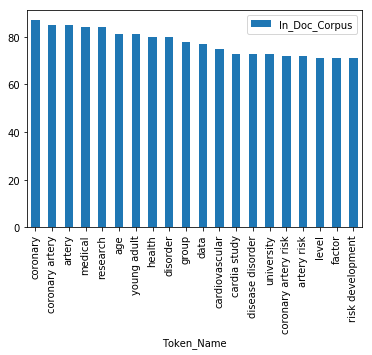

In [34]:
## Review Top terms that occur at least 10 times in entire corpus 

## Add column called "True_In_Document" with an int value of 1
new_df['True_In_Document']= 1
#new_df.head()

corpus_count_df = new_df.groupby(['Token_ID', 'Token_Name'])['True_In_Document'].agg('sum').reset_index().rename(columns={"True_In_Document":"In_Doc_Corpus"})
corpus_count_df.sort_values('In_Doc_Corpus', ascending=False, inplace=True)
corpus_count_df.head()

corpus_count_df.to_csv(r'news_industry_scikitlearn_corpus_count.csv')

top_review_corpus_df = corpus_count_df.iloc[0:20] # first twenty rows of dataframe

top_review_corpus_df.plot(kind='bar', x='Token_Name', y='In_Doc_Corpus')


### Create a word cloud of top terms in corpus

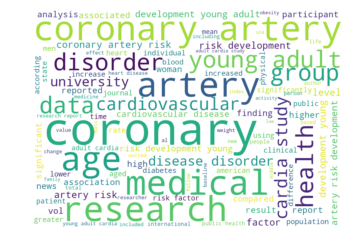

In [35]:
# Make a dictionary of Token_Name and In_Doc_Corpus

dict_for_cloud = dict(zip(corpus_count_df['Token_Name'],corpus_count_df['In_Doc_Corpus']))

# Initialize the word cloud

wordcloud = WordCloud(
    background_color="white",
    max_words=100,
    width = 1024,
    height = 720,
    #stopwords=stopwords.words("english")
)

# Generate the cloud

wordcloud.generate_from_frequencies(dict_for_cloud)


# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# Save the could to a file

#wordcloud.to_file("word_cloud.png")

#https://www.scss.tcd.ie/~munnellg/projects/visualizing-text.html

## Review all terms frequency of occurrence in documents

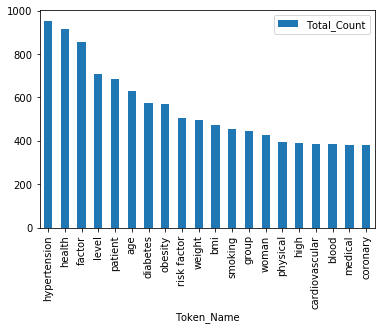

In [36]:
## Review top tokens by word frequency (i.e. count) by summing the number of times the term was found in a document

review_df = new_df.groupby(['Token_ID', 'Token_Name'])['Count_for_Doc'].agg('sum').reset_index().rename(columns={"Count_for_Doc":"Total_Count"})
review_df.sort_values('Total_Count', ascending=False, inplace=True)
review_df.head()

top_review_df = review_df.iloc[0:20] # first twenty rows of dataframe

top_review_df.plot(kind='bar', x='Token_Name', y='Total_Count')



### Create a word cloud of top terms by frequency in documents

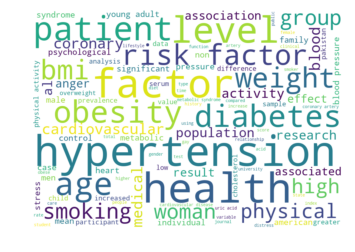

In [37]:
# Make a dictionary of Token_Name and Total_Count

dict_for_cloud_2 = dict(zip(review_df['Token_Name'],review_df['Total_Count']))

# Initialize the word cloud

wordcloud_2 = WordCloud(
    background_color="white",
    max_words=100,
    width = 1024,
    height = 720,
    #stopwords=stopwords.words("english")
)

# Generate the cloud

wordcloud_2.generate_from_frequencies(dict_for_cloud_2)


# Display the generated image:
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")
plt.show()
# Save the could to a file

#wordcloud_2.to_file("word_cloud.png")

#https://www.scss.tcd.ie/~munnellg/projects/visualizing-text.html

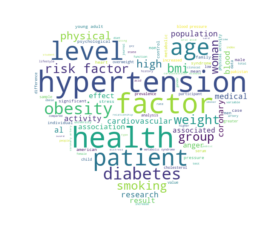

In [29]:
## Create a word cloud using a mask
## <div>Icons made by <a href="https://www.flaticon.com/authors/freepik" title="Freepik">Freepik</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a></div>

mask = np.array(Image.open("like.png"))

# Make a dictionary of Token_Name and Total_Count

dict_for_cloud_3 = dict(zip(review_df['Token_Name'],review_df['Total_Count']))

# Initialize the word cloud

wordcloud_3 = WordCloud(
    background_color="white",
    max_words=100,
    width = 1024,
    height = 720,
    mask = mask
    #stopwords=stopwords.words("english")
)

# Generate the cloud

wordcloud_3.generate_from_frequencies(dict_for_cloud_2)


# Display the generated image:
plt.imshow(wordcloud_3, interpolation='bilinear')
plt.axis("off")
plt.show()
# Save the could to a file

#wordcloud_3.to_file("word_cloud.png")

#https://www.scss.tcd.ie/~munnellg/projects/visualizing-text.html


## Review bigrams by frequency of occurrence in documents

To review the bigrams and their frequency, you can look at them separately using the function below. These n-grams will be included in the count vectorizer, if the ngram_range parameter is set to (1,2) or (1,3)

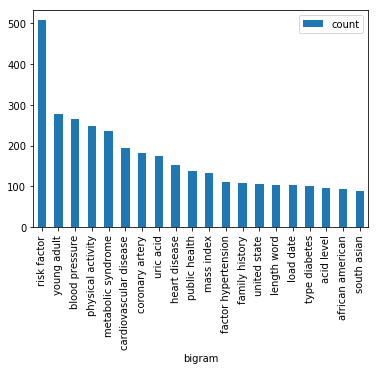

In [38]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(type(bag_of_words))
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(lemmatized_list, 20)

bigrams_df = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

bigrams_df.plot(kind='bar', x='bigram', y='count')

# bigrams_df.to_csv(r'news_industry_scikitlearn_bigrams.csv')

## https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd

## Review trigrams by frequency of occurrence in documents

To review the trigrams and their frequency, you can look at them separately using the function below. These n-grams will be included in the count vectorizer, if the ngram_range parameter is set to (1,3)

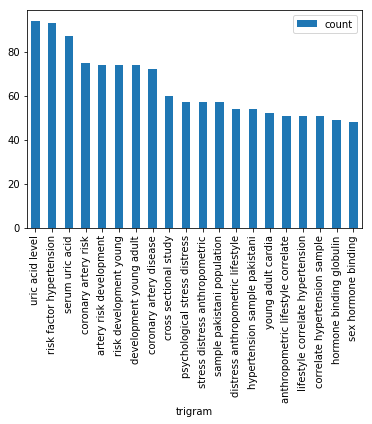

In [31]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(lemmatized_list, 20)

trigrams_df = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
trigrams_df.plot(kind='bar', x='trigram', y='count')

#trigrams_df.to_csv(r'news_industry_scikitlearn_trigrams.csv')


### Training datasets vs. Test datasets for TF-IDF

You can compute the TF-IDF for document(s) that weren't originally in the dataset that you used to create the IDF scores. For example you can create the CountVectorizer and the tfidf_transformer on a training dataset (to build the model) and then use a different testing dataset (to validate the model that was built). 

If you are using a different dataset (i.e. often called a testing dataset), you still need to pre-process, remove stopwords and lemmatize the data. You don't need to create a new CountVectorizer and fit_transform for the data, because you'll use the one you already created. You do not need to calculate IDF scores, since this was done on the training dataset (which is the purpose of the training dataset). Instead you will fit your new dataset to the model you created with the training dataset. And also there is a minor change to the compute_TF_IDF() function (see below). 

1. Get test docs from their dataframe into a list: 
docs_test=df_test['text'].tolist()

2. Preprocess, remove stopwords, and lemmatize the items in the list (use functions already created). 

3. Modify the compute_TF_IDF function: 

def compute_TF_IDF(docs_test, tfidf_transformer, cv):
    
    tf_idf_vector=tfidf_transformer.transform(**cv.transform(docs_test)**)
        
    return tf_idf_vector

tf_idf_vector = compute_TF_IDF(docs_test, tfidf_transformer, cv)


**Text from:**
* <https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X8Jt9NBKiUk>

In [32]:
## Load test dataset
# directory = "practice_pdfs_2"
# files = list(glob.glob(os.path.join(directory,'*.*')))
# print(files)

In [33]:
#https://stackoverflow.com/questions/34837707/how-to-extract-text-from-a-pdf-file
# document_list_2 = []
# for f in files:
#     raw = parser.from_file(f)
#     document_list_2.append(raw)

In [34]:
# text_df_2 = pd.DataFrame(document_list_2)
##text_df.head()
##print(text_df["content"][1])

In [35]:
# Convert the "content" column in dataframe to a list

# convert_content_to_list(text_df_2)

# print(type(content_list))
# print(content_list[0])

In [36]:
## Pre-process the text to lower case, remove special characters, etc. 
## https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.X7RHltBKiUn
## Test regex here: https://pythex.org/

## New column "preprocess" is formed from applying pre_process function to each item in the "content" column in dataframe
# text_df_2['preprocess'] = text_df_2['content'].apply(lambda x:preprocess(x))

# print(text_df_2['preprocess'][1])

## https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

In [37]:
## Get stopwords

# stopwords=get_stop_words("stop_words.txt")

In [38]:
## Lemmatize documents

## New column "lemmatize" is formed from applying pre_process function to each item in the "preprocess" column in dataframe
# text_df_2['lemmatize'] = text_df_2['preprocess'].apply(lambda x:lemmatize(x, stopwords))

# print(text_df_2['lemmatize'][1])


In [39]:
## Convert the "lemmatized" column in dataframe to a list

# convert_lemmatized_to_list(text_df_2)
# print(type(lemmatized_list))
# print(len(lemmatized_list))
# print(lemmatized_list[1])

In [40]:
# def compute_TF_IDF_2(docs_test, tfidf_transformer, cv):

#     tf_idf_vector=tfidf_transformer.transform(cv.transform(docs_test))

#     return tf_idf_vector

# tf_idf_vector = compute_TF_IDF_2(lemmatized_list, tfidf_transformer, cv)

In [41]:
## Organize data into dataframes and join to show final results

## The todense() function acts as a dataframe contructor for a numpy matrix
# tf_idf_df_all_2 = pd.DataFrame(tf_idf_vector.todense())

## The .stack() function returns a Pandas.Series, which in this case has a multi-level index
## The return is: multi-level index of doc, token_id, and a value of tfidf

# tf_idf_sr_all_2 = tf_idf_df_all_2.stack()

## Review the data by retrieving the first five elements in the Series
#print(tf_idf_sr_all[:5])

## Review the data by retrieving the 3rd through 6th elements in the Series using loc function
#print(tf_idf_sr_all.loc[3:4])

## Review the data by printing the series index
#print(tf_idf_sr_all.index) 

## Now, turn the Series into dataframe
## Use reset_index(inplace=True) to set the multi-level index as columns

# tf_idf_df_final_2=pd.DataFrame(tf_idf_sr_all_2)
# tf_idf_df_final_2.reset_index(inplace=True)

## Change the column names to something more useful
## The "inplace = True" means the original dataframe is changed
# tf_idf_df_final_2.rename(columns={'level_0': 'Document_ID', 'level_1': 'Token_ID', 0: 'TF_IDF_for_Doc'}, inplace=True)
# tf_idf_df_final_2.head(50)

## Resources
## https://www.geeksforgeeks.org/python-pandas-series-index/#:~:text=index,-Last%20Updated%3A%2028&text=The%20object%20supports%20both%20integer,performing%20operations%20involving%20the%20index.
## https://discuss.analyticsvidhya.com/t/how-to-convert-the-multi-index-series-into-a-data-frame-in-python/5119/2

                                                      

### Check the Sparcity of the data

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

Resource:<https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn>

In [39]:
# Materialize the sparse data
data_dense = word_count_vector.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity (percent of cells contain non-zero): ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity (percent of cells contain non-zero):  5.610097087378641 %


## Topic Modeling with ScikitLearn using LDA

Topic Modelling is an unsupervised Machine Learning task where we try to discover “abstract topics” that can describe a collection of documents. For example, let’s say we have a collection of 100 texts. We go through each text and discover that ten of them contain words like “machine learning”, “training”, “supervised”, “unsupervised”, “dataset” and so on. We may not know what these words mean and we really don’t care. We only see a pattern here, that 10% of our articles contain these words and we conclude that they should be included in the same topic. We can’t actually name the topic and again, this is not needed. We are able to cluster these 10 articles into the same topic. And when we get a new text which we have never seen before, we look into it, we find it contains some of these words, then we’ll be able to say “hey, this goes into the same category with the other 10 articles!”

Our first step is to build an LDA model with scikitlearn. We need to set the number of topics (usually start with 5 to 10 topics) and choose a learning decay state (usually: 0.5, 0.7, or 0.9). Later we will test our LDA model to identify the best number of topics and the setting for learning decay. 

The LatentDirichletAllocation() function works like this: 

Assign every word in every document to a temporary topic. This temporary topic will be random at first, but will be updated in the next step.For this step, we will go through every document and then every word in that document and compute 2 values:
* the probability that this document belongs to a certain topic; this is based on how many words(except the current word) from this document belong to the topic of the current word
* the proportion of documents that are assigned to the topic of the current word because of the current word.

This step is completed a certain number of times (established before beginning to run the algorithm). In the end, we will look at each document, find the topic that is most prevalent based on its words and assign that document to that topic.

**How it wants the data:** The LDA topic model algorithm requires a document word matrix as the main input. You can create one using CountVectorizer (see steps above to create cv) and the output of the fit_transform, which we called word_count_vector. 

**Expected Return:** After calling fit_transform on the lda_model, the return is an array which contains a the number of probabilities that our text belongs to each of the number of topics we've asked for. 

For example, if there are three numbers for each item in the array, then these 3 numbers are probabilities that our text belongs to one of the 3 topics we’ve generated from the LDA algorithm. We can see that the highest probability(72%) tells us that this text should also belong to the 3rd topic, so in the same topic that talks about cities. We can see that this is a very good result obtained from a very small dataset.

Text from: <https://towardsdatascience.com/latent-dirichlet-allocation-for-topic-modelling-explained-algorithm-and-python-scikit-learn-c65a82e7304d>

In [17]:
## Build the LDA Model


feature_names = cv.get_feature_names()
num_of_topic = 2

lda_model = LatentDirichletAllocation(
                n_components=num_of_topic, 
                max_iter=5, 
                learning_method='online', 
                random_state=0,
                learning_decay=0.9)

lda_output = lda_model.fit_transform(word_count_vector)
#print(lda_output)# Model attributes

##https://towardsdatascience.com/2-latent-methods-for-dimension-reduction-and-topic-modeling-20ff6d7d547#:~:text=Both%20LSA%20and%20LDA%20have,LDA%20solves%20topic%20modeling%20problems.



In [18]:
def display_word_distribution(model, feature_names, n_word):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        words = []
        for i in topic.argsort()[:-n_word - 1:-1]:
            words.append(feature_names[i])
        print(words)

display_word_distribution(
    model=lda_model, feature_names=feature_names, 
    n_word=10)

## n_word here is the number of terms to print for each topic

Topic 0:
['hypertension', 'study', 'risk', 'factor', 'disease', 'health', 'level', 'age', 'year', 'patient']
Topic 1:
['study', 'risk', 'health', 'obesity', 'year', 'adult', 'disease', 'diabetes', 'patient', 'weight']


### Diagnose model performance with perplexity and log-likelihood

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn>

In [19]:
## A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.
## https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(word_count_vector))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(word_count_vector))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1326379.6639765273
Perplexity:  3969.11899414872
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.9,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 2,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### Using GridSearch to find the best LDA Model

The most important tuning parameter for LDA models is n_components (number of topics). In addition, we will search learning_decay (which controls the learning rate) as well.

Be warned, the grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn>

**What is GridSearch?**
Gridsearch helps us establish the best hyperparameters for our model. A machine learning model has multiple parameters that are not trained by the training set. These parameters control the accuracy of the model. Therefore, the hyperparameters are particularly important in a data science project.The hyperparameters are configured up-front and are provided by the caller of the model before the model is trained.

Text from: <https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a>



In [20]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(word_count_vector)


## A more in-depth version of the code above

# GridSearchCV(cv=None, error_score='raise',
#        estimator=LatentDirichletAllocation(batch_size=128, 
#                                            doc_topic_prior=None,
#                                            evaluate_every=-1, 
#                                            learning_decay=0.7, 
#                                            learning_method=None,
#                                            learning_offset=10.0, 
#                                            max_doc_update_iter=100, 
#                                            max_iter=10,
#                                            mean_change_tol=0.001, 
#                                            n_components=10, 
#                                            n_jobs=1,
#                                            perp_tol=0.1, 
#                                            random_state=None,
#                                            topic_word_prior=None, 
#                                            total_samples=1000000.0, 
#                                            verbose=0),
#                                            #fit_params=None, 
#                                            #iid=True, 
#                                            #n_jobs=1,
#        param_grid={'n_components': [2, 4, 6, 8, 10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
#        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#        scoring=None, verbose=0)


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 4, 6, 8, 10, 15, 20, 25, 30]})

### Printing the best parameters using GridSearch

In [21]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(word_count_vector))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 2}
Best Log Likelihood Score:  -318512.30670754274
Model Perplexity:  3696.3022058791407


In [45]:
## Grid search returns a number of results. Here we can view those results in a pandas dataframe
# model.cv_results_.keys()
# model.cv_results_.values()

results_df = pd.DataFrame.from_dict(model.cv_results_)
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.849414,0.101553,0.021344,0.005069,0.5,2,"{'learning_decay': 0.5, 'n_components': 2}",-661832.939051,-489545.413082,-128419.673991,-142830.572333,-125329.545858,-309591.628863,224072.464840,3
1,0.937580,0.116455,0.026939,0.011761,0.5,4,"{'learning_decay': 0.5, 'n_components': 4}",-701119.389004,-514615.919075,-144107.225057,-157823.411471,-139514.572782,-331436.103478,233361.490354,4
2,1.162152,0.211836,0.035307,0.014881,0.5,6,"{'learning_decay': 0.5, 'n_components': 6}",-738090.757279,-539818.907386,-156263.251387,-171223.823100,-152761.353344,-351631.618499,242911.619943,8
3,1.309713,0.188159,0.038908,0.024061,0.5,8,"{'learning_decay': 0.5, 'n_components': 8}",-773212.187210,-563445.155935,-166658.873398,-181371.362847,-164259.775637,-369789.471006,252688.856541,11
4,1.815927,0.465922,0.055751,0.034049,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-805699.585924,-586323.648245,-175118.854590,-190281.347834,-172626.075154,-386009.902350,262519.479689,13


### Compare LDA Model Performance Scores 
Though we found the best scores above, here we can visualize the results of the analysis used to find those scores. 

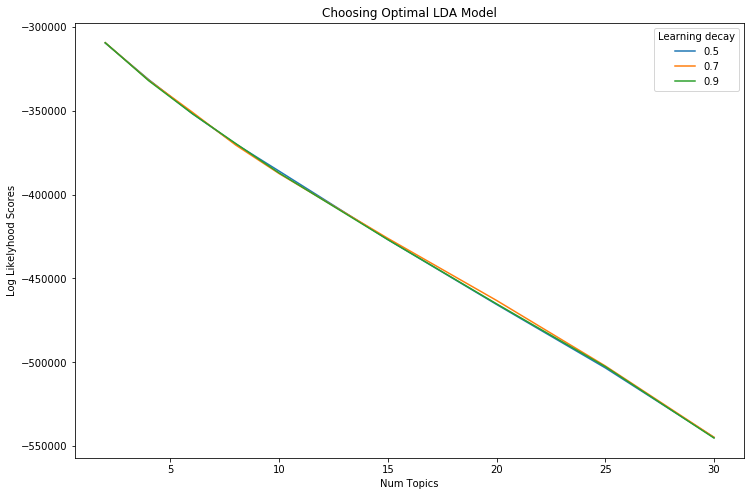

In [46]:
# Get Log Likelyhoods from Grid Search Output
n_components = [2, 4, 6, 8, 10, 15, 20, 25, 30]

 
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_components, log_likelyhoods_5, label='0.5')
plt.plot(n_components, log_likelyhoods_7, label='0.7')
plt.plot(n_components, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

### How to see the dominant topic in each document?

To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In the table below, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column.

Note: The number in the dominate topic column corresponds the number of the topic for which the document is most like. 

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn>

In [47]:
## Turn original dataframe of text to a list
data = text_df.values.tolist()

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(word_count_vector)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,dominant_topic
Doc0,0.000000,1.000000,1
Doc1,0.000000,1.000000,1
Doc2,0.000000,1.000000,1
Doc3,0.000000,1.000000,1
Doc4,0.920000,0.080000,0
Doc5,0.990000,0.010000,0
Doc6,0.000000,1.000000,1
Doc7,1.000000,0.000000,0
Doc8,1.000000,0.000000,0
Doc9,0.000000,1.000000,1


### Review topics distribution across documents


In [48]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,55
1,1,48


### Visualizing the LDA model with pyLDAvis
The pyLDAvis offers the best visualization to view the topics-keywords

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn>

In [49]:
## A good topic model will have non-overlapping, fairly big sized blobs for each topic. 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, word_count_vector, cv, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  58.686926
1      60.312561 -141.369141       2        1  41.313074, topic_info=              Term        Freq       Total Category  logprob  loglift
4169  hypertension  908.000000  908.000000  Default  30.0000  30.0000
6606       patient  636.000000  636.000000  Default  29.0000  29.0000
469          anger  305.000000  305.000000  Default  28.0000  28.0000
3570           gay  163.000000  163.000000  Default  27.0000  27.0000
566    appointment  133.000000  133.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
3140        factor  182.648302  811.004508   Topic2  -5.8484  -0.6067
7678      research  134.979959  335.262066   Topic2  -6.1508  -0.0258
409       american  122.901321  251.835730   Topic2  -6.2445   0.1666
1282          case  123.766660  268.006536   Topic2  -6.2375   0.1114
2749        effect  122.433735  294.742927   Topic2  -6.2483   0.0055

[180 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
93        1  0.561750     activity
93        2  0.438509     activity
261       1  0.580871          age
261       2  0.418767          age
325       2  1.000001   aggression
...     ...       ...          ...
9769      2  0.372780        woman
9919      1  0.049947          yes
9919      2  0.961479          yes
9940      1  0.721820  young adult
9940      2  0.277331  young adult

[210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

### Viewing all of the topic’s keywords
The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

Text from <https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn>

In [50]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = cv.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aa,abbas,abdominal,abdominal central,abdominal central fat,abdominal fat,abdominal obesity,abdul,ability,able,...,zhu,zoler,zoler philadelphia,zoler philadelphia bureau,zoler philadelphia hyperuricemia,zone,zubair,zulfiqar,zulfiqar jan,zulfiqar jan rehman
Topic0,9.118156,3.765691,30.165766,6.499994,6.499994,4.933291,12.49879,2.494897,3.602325,2.685783,...,3.662462,7.497903,6.499075,2.49601,4.499949,3.69647,0.500014,6.499994,6.499994,6.499994
Topic1,0.881844,1.234309,0.834234,0.500006,0.500006,2.066709,0.50121,2.505103,6.397675,7.314217,...,7.337538,4.502097,4.500925,4.50399,0.500051,5.30353,4.499986,0.500006,0.500006,0.500006


### Get the top 15 keywords each topic

In [51]:
# Show top n keywords for each topic
def show_topics(vectorizer=cv, lda_model=lda_model, n_words=15):
    keywords = np.array(cv.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,hypertension,factor,risk factor,bmi,health,level,obesity,diabetes,age,blood,smoking,weight,population,psychological,al
Topic 1,health,patient,level,anger,age,coronary,child,weight,factor,group,diabetes,obesity,high,gay,physical


### Preditcting the topics for a new piece of text

Assuming that you have already built the topic model, you need to take the text through the same routine of transformations and before predicting the topic.

For our case, the order of transformations is:

sent_to_words() –> lemmatization() –> vectorizer.transform() –> best_lda_model.transform()

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn>

In [ ]:
## NOTE!! This codes does not conform to my code here...just sample code from the url above

## Define function to predict topic for a given text document.
# nlp = spacy.load('en', disable=['parser', 'ner'])

# def predict_topic(text, nlp=nlp):
#     global sent_to_words
#     global lemmatization

#     # Step 1: Clean with simple_preprocess
#     mytext_2 = list(sent_to_words(text))

#     # Step 2: Lemmatize
#     mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#     # Step 3: Vectorize transform
#     mytext_4 = vectorizer.transform(mytext_3)

#     # Step 4: LDA Transform
#     topic_probability_scores = best_lda_model.transform(mytext_4)
#     topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
#     return topic, topic_probability_scores

# # Predict the topic
# mytext = ["Some text about christianity and bible"]
# topic, prob_scores = predict_topic(text = mytext)
# print(topic)

### How to cluster documents that share similar topics and plot?
You can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. The k-means clustering method is an unsupervised machine learning technique used to identify clusters of data objects in a dataset. Because our best model has 2 clusters, we've set n_clusters=2 in KMeans().Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#20howtoclusterdocumentsthatsharesimilartopicsandplot>

The k-means clustering method is an unsupervised machine learning technique used to identify clusters of data objects in a dataset.

Text from: <https://realpython.com/k-means-clustering-python/>

In [52]:
## Construct the k-means clusters

clusters = KMeans(n_clusters=2, random_state=100).fit(lda_output)
# clusters.inertia_ ## The lowest SSE value
# clusters.cluster_centers_ ## Final locations of the centroid
# clusters.n_iter_ ## The number of iterations required to converge


clusters_2 = KMeans(n_clusters=2, random_state=100).fit_transform(lda_output)
print(clusters_2)

## Build the Singular Value Decomposition(SVD) model
## Use code when you have more than 2 clusters
#svd_model = TruncatedSVD(n_components=2)  
#lda_output_svd = svd_model.fit_transform(lda_output)

# ## X and Y axes of the plot using SVD decomposition
# x = lda_output_svd[:, 0]
# y = lda_output_svd[:, 1]

# ## Weights for the 15 columns of lda_output, for each component
# print("Component's weights: \n", np.round(svd_model.components_, 2))

# ## Percentage of total information in 'lda_output' explained by the two components
# print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

## Use this code when you have equal to or less than 2 clusters
x = lda_output[:, 0]
y = lda_output[:, 1]


[[1.39079468 0.12779243]
 [1.39139877 0.12839652]
 [1.39036929 0.12736704]
 [1.39161282 0.12861057]
 [0.08652448 1.17647777]
 [0.01099691 1.27399916]
 [1.39146791 0.12846566]
 [0.02200392 1.28500618]
 [0.02197749 1.28497974]
 [1.39118127 0.12817901]
 [0.02195926 1.28496151]
 [1.39125293 0.12825068]
 [1.39125245 0.12825019]
 [1.07848821 0.18451404]
 [0.02236197 1.28536422]
 [0.02236197 1.28536422]
 [0.01737936 1.28038161]
 [0.02236197 1.28536422]
 [0.02091439 1.28391664]
 [0.02173039 1.28473265]
 [0.73108335 0.5319189 ]
 [0.80210167 0.46090058]
 [0.74420524 0.51879701]
 [0.0220152  1.28501746]
 [0.02152718 1.28452943]
 [1.39140356 0.1284013 ]
 [0.02206113 1.28506338]
 [0.02189723 1.28489949]
 [0.02167555 1.28467781]
 [0.0223105  1.28531276]
 [1.39159949 0.12859724]
 [0.00884709 1.25415516]
 [0.02219229 1.28519455]
 [0.02219214 1.2851944 ]
 [1.39044813 0.12744587]
 [1.15169935 0.1113029 ]
 [1.39017699 0.12717474]
 [0.02006974 1.283072  ]
 [0.02029192 1.28329417]
 [0.01844761 1.28144987]


### Visualize the clusters

We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, you can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components.

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#20howtoclusterdocumentsthatsharesimilartopicsandplot>

Text(0.5, 1.0, 'Segregation of Topic Clusters')

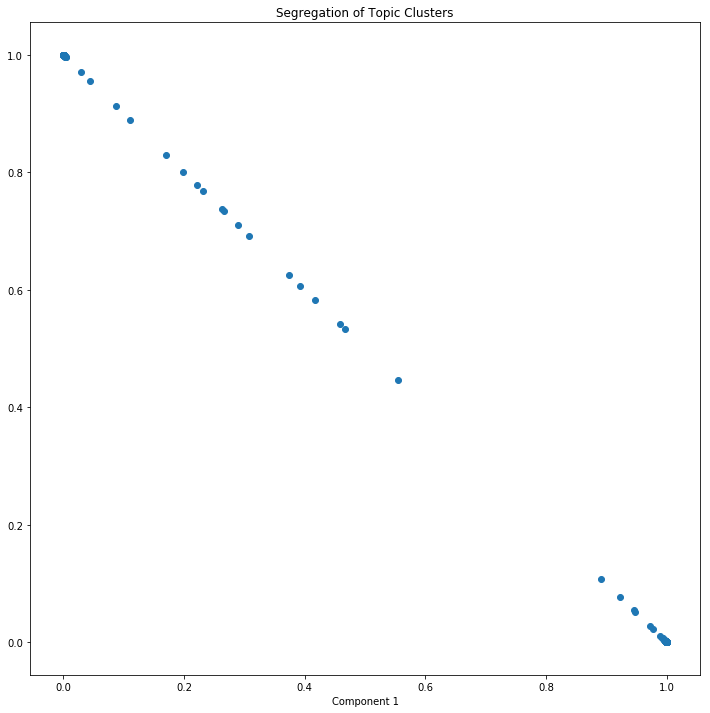

In [53]:
## We have the X, Y and the cluster number for each document.

## Let’s plot the document along the two SVD decomposed components. The color of points represents the cluster number (in this case) or topic number.

## Use this code when you have only 2 clusters
x = lda_output[:, 0]
y = lda_output[:, 1]

## Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

### Using NMF instead of LDA

In [54]:
## NMF is able to use tf-idf
## TFIDF VEctorize is Equivalent to CountVectorizer followed by TfidfTransformer.
## Set parameters for TFIDF Vectorize
    ## Ignore words that appear in 85% of documents, 
    ## Eliminate stop words
    ## Include tokens with one word or two word phrases, (1, 2) means unigrams and bigrams
    ## Run the preprocess function 
    ## Limit our vocabulary size to 10,000
    ## Ignore words that only appear in 1 document
    
tfidf_vectorizer = TfidfVectorizer(max_df=0.85,
                                   stop_words='english',
                                   ngram_range=(1, 3),
                                   max_features=10000,
                                   min_df=1, 
                                   )
tfidf = tfidf_vectorizer.fit_transform(lemmatized_list)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()



In [55]:
no_topics = 2
# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)



In [56]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
no_top_features = 15
def display_topics(model, feature_names, no_top_features):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic:" ,(topic_idx))
        print (", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_features - 1:-1]]))

display_topics(nmf, tfidf_feature_names, no_top_features)

Topic: 0
hypertension, psychological, distress, factor, stress, risk factor, stress distress, anger, factor hypertension, blood pressure, pressure, blood, activity, risk factor hypertension, anthropometric lifestyle
Topic: 1
uric, uric acid, acid, diabetes, hyperuricemia, krishnan, uric acid level, acid level, type diabetes, serum uric, serum uric acid, level, type, baseline, serum
